Уравнения:

$\frac{1}{2}(M + m) \ddot{x} - ml\ddot{\theta} cos(\theta) + ml\dot{\theta}^2 sin(\theta) = F$

$l\ddot{\theta} - gsin(\theta) = \ddot{x}cos{\theta}$

$$\ddot{x} = \frac{l\ddot{\theta} - gsin(\theta)}{cos{\theta}} $$

$$F = \frac{1}{2}(M + m)\frac{l\ddot{\theta} - gsin(\theta)}{cos{\theta}}   - ml\ddot{\theta} cos(\theta) + ml\dot{\theta}^2 sin(\theta)$$

$$M = 0 \space \space \to$$ 

$$F = \frac{1}{2}ml\ddot{\theta}(\frac{1}{cos(\theta)} - 2cos(\theta)) + ml \dot{\theta}^2 sin(\theta) - \frac{1}{2} mg tg(\theta) $$

In [33]:
#Начальное значение
from math import *


class Params:

    def __init__(self):

        self.m = 0.1
        self.M = 1.
        self.l = 0.3
        self.g = 9.8

In [34]:
import numpy as np


def right_equasion(t, x, p, u):
    
    dxdt = np.zeros(4)
    dxdt[0] = x[1]
    dxdt[1] = (-p.m * p.g * cos(x[2]) * sin(x[2]) + p.m * p.l * sin(x[2]) * x[3] ** 2 + u) / (
            p.M + p.m * sin(x[2]) ** 2) + 20 * sin(20 * pi * t)
    dxdt[2] = x[3]
    dxdt[3] = (-p.m * p.l * cos(x[2]) * sin(x[2]) * x[3] ** 2 - cos(x[2]) * u + (p.M + p.m) * p.g * sin(x[2])) / (
            p.M * p.l + p.m * p.l * sin(x[2]) ** 2) + 20 * sin(20 * pi * t)
    
    return dxdt


In [35]:
class PID_Controller():
    def __init__(self, dt, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integral = 0
        self.e_prev = None

    def update(self, state, reference):
        error = state - reference
        if self.e_prev is None:
            dedt = 0
        else:
            # первый порядок апроксимации
            dedt = (error - self.e_prev) / self.dt
        
        self.integral = self.integral + error * self.dt

        self.e_prev = error
        return self.kp * error + self.ki * self.integral + self.kd * dedt


In [36]:
def ra(t):
    return 0


def rp(t):
    return 0.3 * sin(0.05 * pi * t)


from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def solve(t0, tf, dt, x0, p, pid1, pid2):
    
    t = np.arange(t0, tf, dt)
    res = x0
    f = []

    for i in range(len(t) - 1):
        
        u = pid1.update(x0[2], ra(t[i])) - pid2.update(x0[0], rp(t[i]))
        f = np.append(f, u)
        solution = solve_ivp(lambda t, x: right_equasion(t, x, p, u), (t[i], t[i + 1]), x0)
        x0 = solution.y[:, -1]
        
        if abs(x0[0]) > 0.5:
            
            x0[0] = 0.5 * np.sign(x0[0])
        
        res = np.vstack((res, x0))

    return t, f, res

In [37]:
t_0 = 0
t_f = 100
d_t = 0.01
init = [0., 0., 0.5, 0.]
param = Params()

pid1 = PID_Controller(d_t, 2, 4, 7)
pid2 = PID_Controller(d_t, 3, 2, 8)

[t, f, x] = solve(t_0, t_f, d_t, init, param, pid1, pid2)

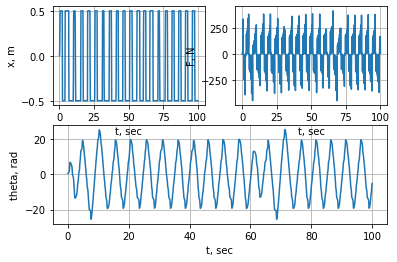

In [38]:


ax = plt.subplot(2,1,2)

ax.plot(t, x[:, 2])
ax.set_xlabel('t, sec')
ax.set_ylabel('theta, rad')
ax.grid()

ax = plt.subplot(2, 2, 1)
ax.plot(t, x[:, 0])
ax.set_xlabel('t, sec')
ax.set_ylabel('x, m')
ax.grid()

ax = plt.subplot(2, 2, 2)
ax.plot(t[0:-1], f)
ax.set_xlabel('t, sec')
ax.set_ylabel('F, N')
ax.grid()

plt.savefig("file1.jpeg")
